**MNIST Dataset Handwritten Digits Recognition**

In [0]:
import numpy as np
from skimage.feature import hog
from sklearn import preprocessing
from collections import Counter
from sklearn.datasets import fetch_openml
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

#from sklearn.datasets import fetch_mldata
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization,Input
from keras.models import Model,load_model
from IPython.display import SVG
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


 **1.2 Load Kaggle Kuzushiji Recognition Dataset**

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install kaggle

In [39]:
from google.colab import files
files.upload() #this will prompt you to update the json

Saving kaggle (2).json to kaggle (2) (1).json


In [0]:
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [48]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c kuzushiji-recognition

  0% 0.00/51.5k [00:00<?, ?B/s]
100% 51.5k/51.5k [00:00<00:00, 46.4MB/s]
  0% 0.00/146k [00:00<?, ?B/s]
100% 146k/146k [00:00<00:00, 48.2MB/s]
 88% 5.00M/5.67M [00:00<00:00, 24.5MB/s]
100% 5.67M/5.67M [00:00<00:00, 22.2MB/s]
100% 3.58G/3.58G [01:02<00:00, 57.7MB/s]
100% 3.58G/3.58G [01:02<00:00, 61.9MB/s]
 99% 3.02G/3.03G [00:37<00:00, 86.0MB/s]
100% 3.03G/3.03G [00:37<00:00, 87.3MB/s]


Load font that can display the full range of Japanese characters. We're using Noto Sans, an open source font by Google.

In [49]:
fontsize = 50

# From https://www.google.com/get/noto/
!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
!rm NotoSansCJKjp-hinted.zip

font = ImageFont.truetype('./NotoSansCJKjp-Regular.otf', fontsize, encoding='utf-8')


NotoSansCJKjp-hinte 100%[===================>] 115.49M  51.7MB/s    in 2.2s    


**2.1 Visualising the training data**

In [0]:
!unzip -q "/content/train.csv.zip"

In [0]:
df_train = pd.read_csv('/content/train.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('/content/unicode_translation.csv').values}
unicode_map

In [52]:
df_train.isnull().sum()

image_id      0
labels      276
dtype: int64

In [0]:
# This function takes in a filename of an image, and the labels in the string format given in train.csv, and returns an image containing the bounding boxes and characters annotated
def visualize_training_data(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 5)
    #print(labels)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        char = unicode_map[codepoint] # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
        char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(0, 0, 255, 255), font=font)
        Croped_image = imsource.crop((x, y, x+w, y+h))
        plt.figure()
        print(str(unicode_map[codepoint]))
        plt.imshow(Croped_image)
        plt.show()

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

In [0]:
!mkdir -p "/content/sample_data/TrainData"

In [0]:
!mkdir -p "/content/sample_data/TestImages"

In [0]:
!unzip -q "/content/train_images.zip" -d "/content/sample_data/TrainData"

In [0]:
!unzip -q "/content/test_images.zip" -d "/content/sample_data/TestImages"

ヽ


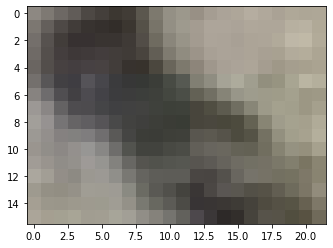

一


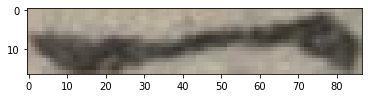

ヽ


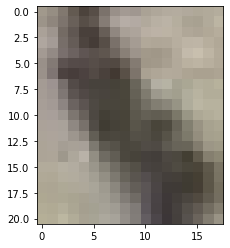

へ


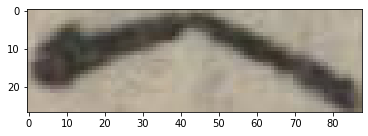

へ


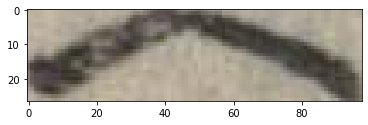

ゝ


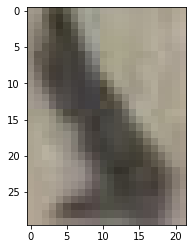

ニ


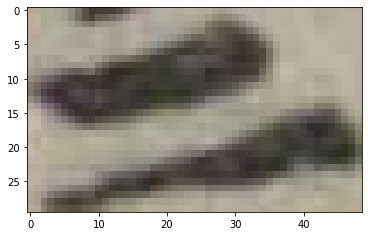

へ


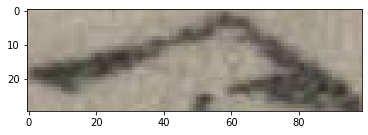

ヽ


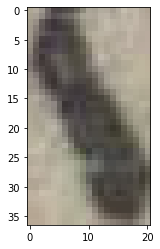

ハ


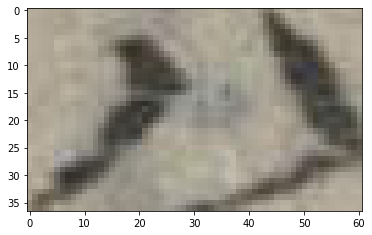

ノ


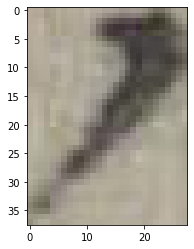

ン


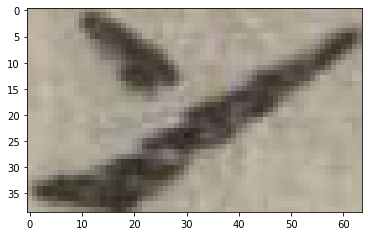

へ


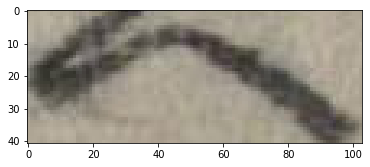

へ


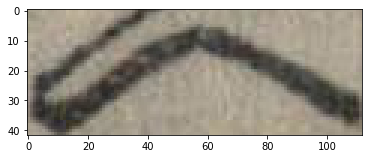

は


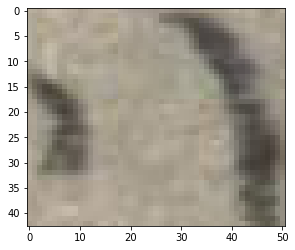

ア


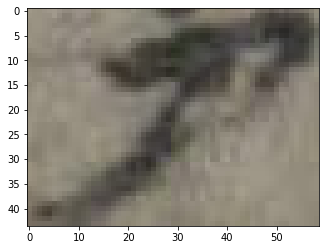

は


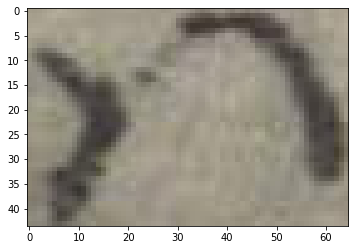

る


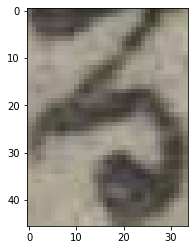

こ


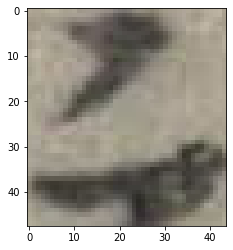

い


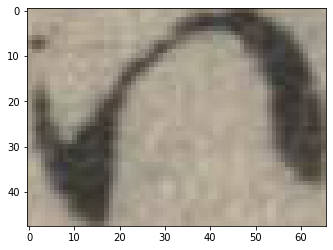

か


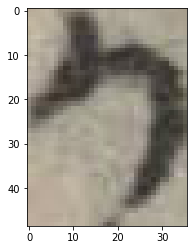

い


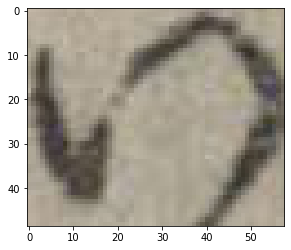

は


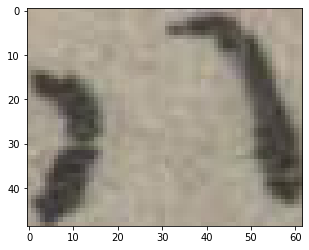

へ


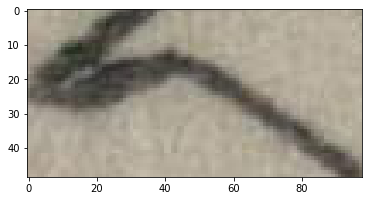

や


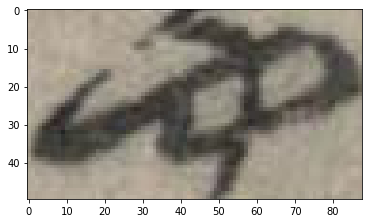

ツ


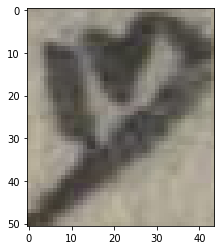

か


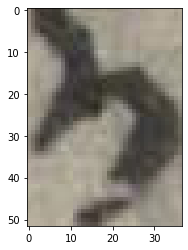

か


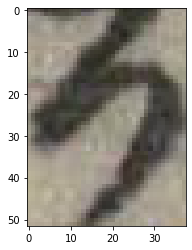

が


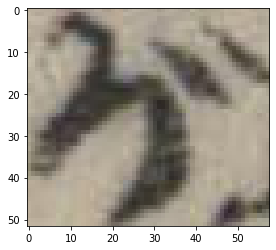

の


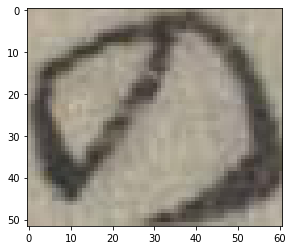

は


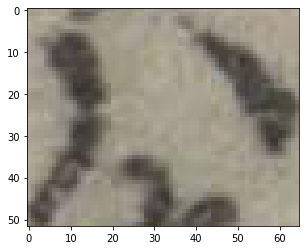

ぺ


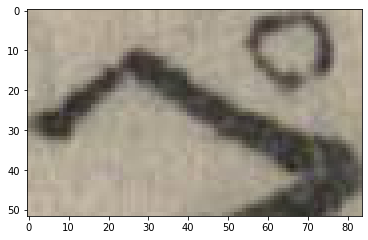

ナ


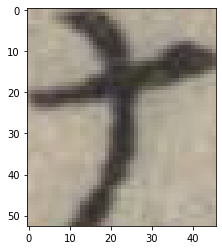

モ


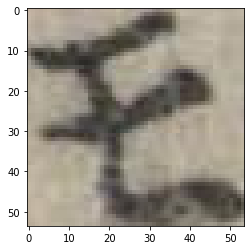

の


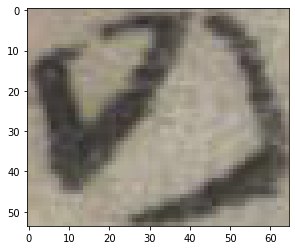

い


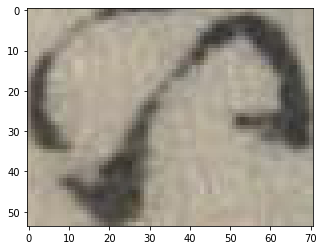

や


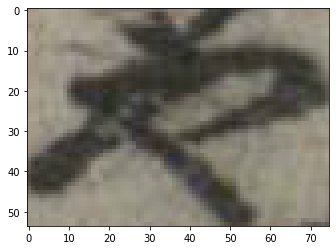

イ


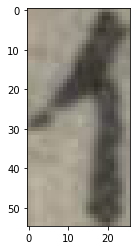

こ


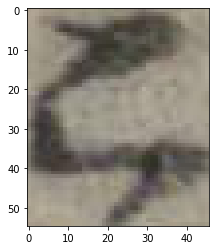

も


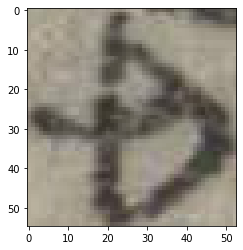

が


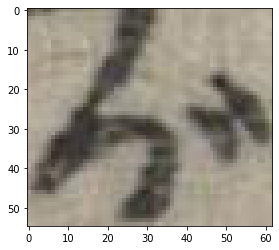

〻


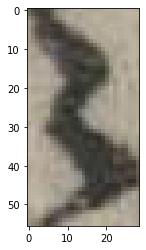

は


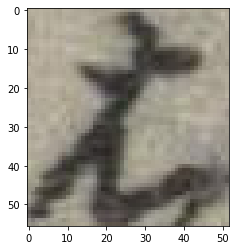

る


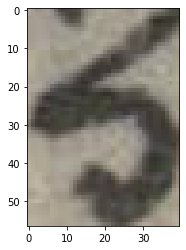

る


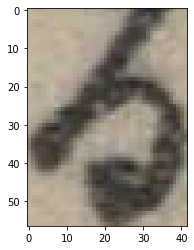

た


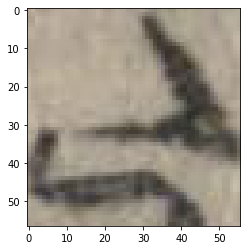

ん


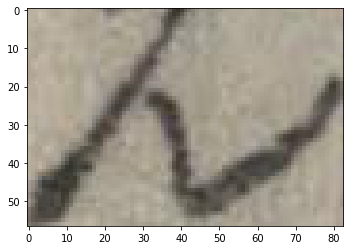

は


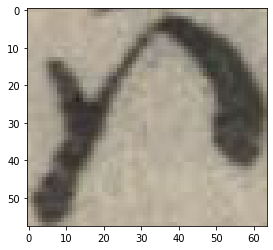

た


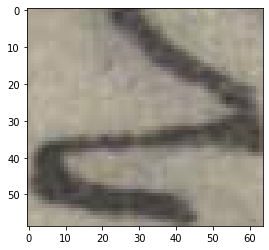

お


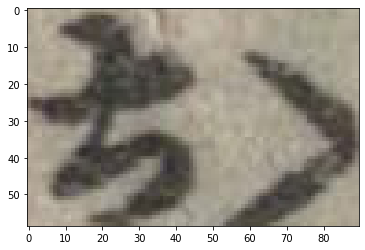

ア


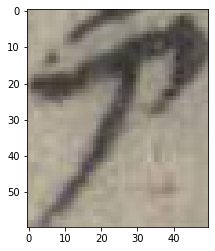

ノ


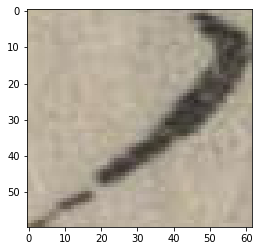

た


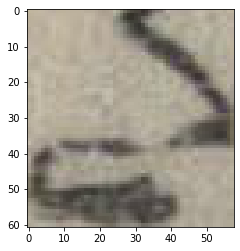

た


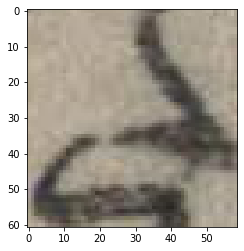

ホ


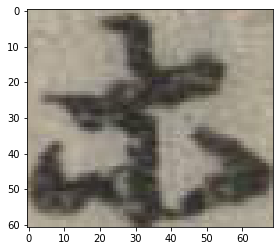

や


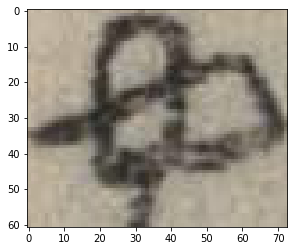

て


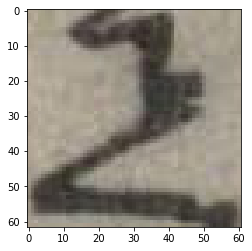

つ


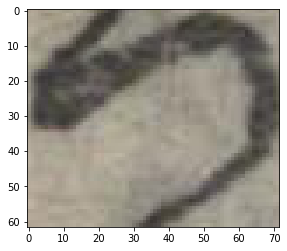

で


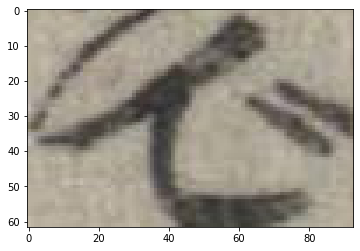

で


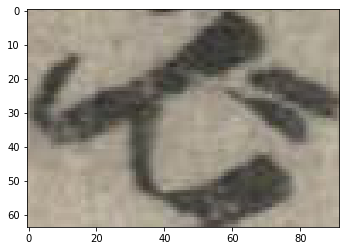

が


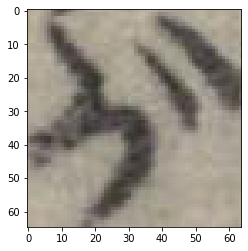

の


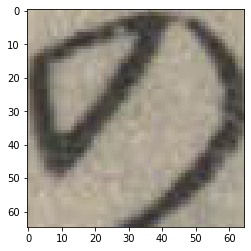

ホ


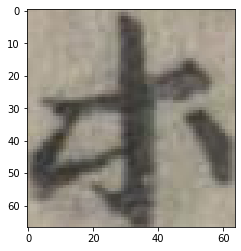

出


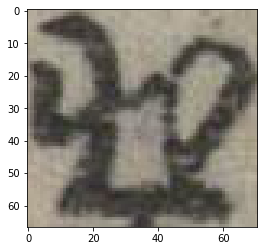

で


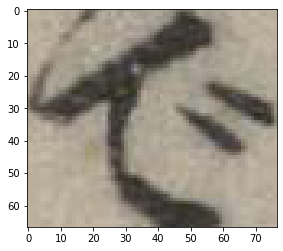

て


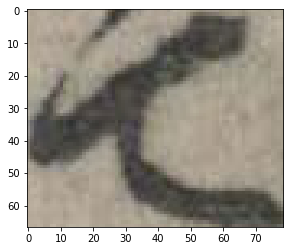

や


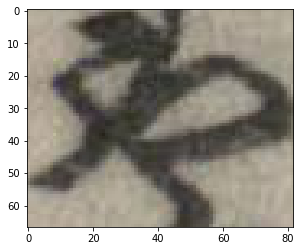

出


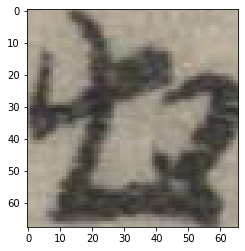

だ


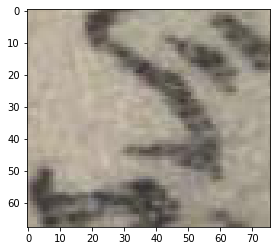

ど


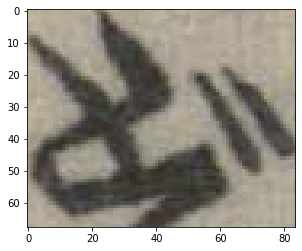

つ


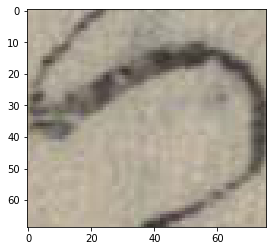

に


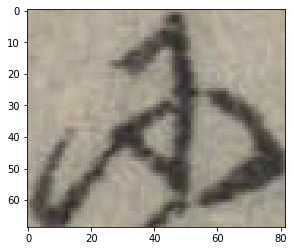

も


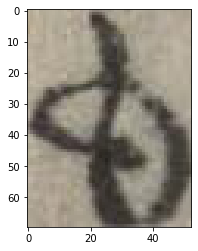

ぢ


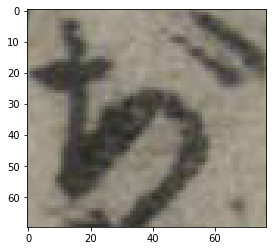

た


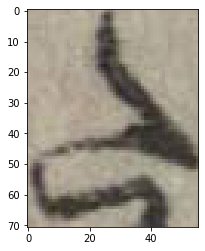

に


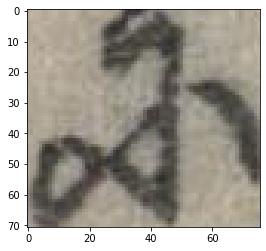

ん


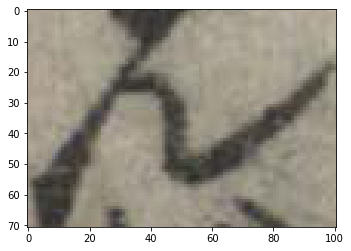

さ


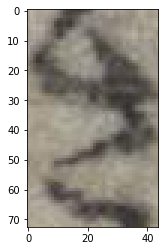

さ


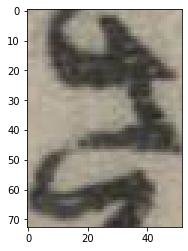

て


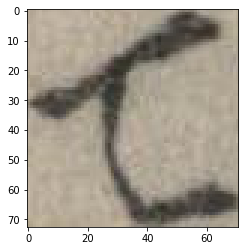

に


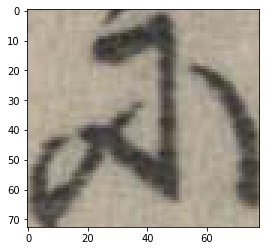

て


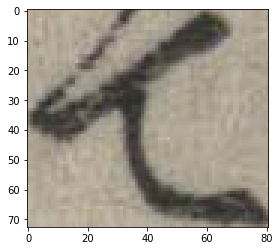

ざ


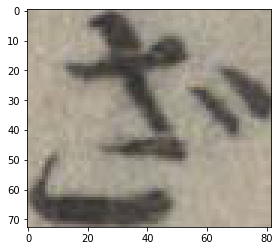

ふ


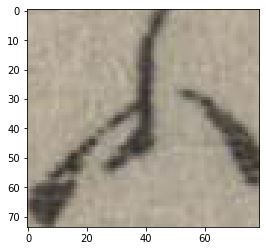

お


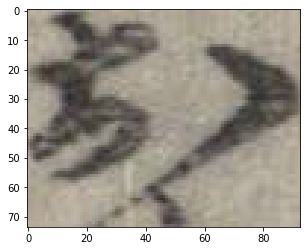

は


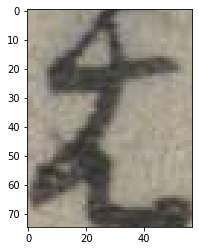

に


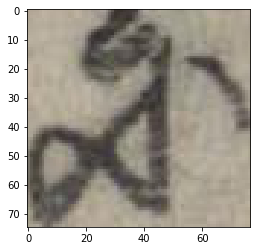

ね


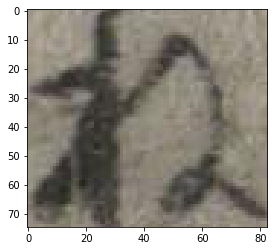

奴


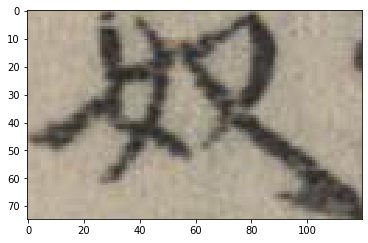

も


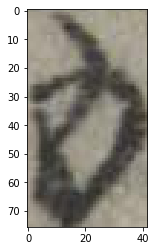

と


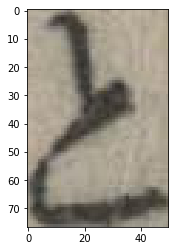

に


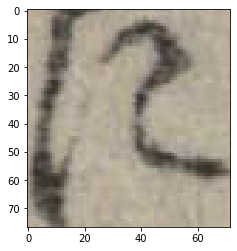

小


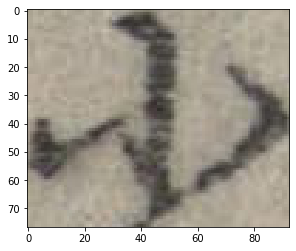

ん


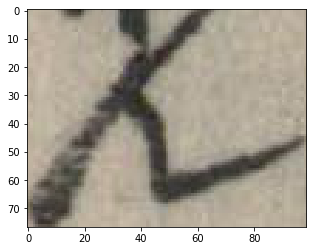

だ


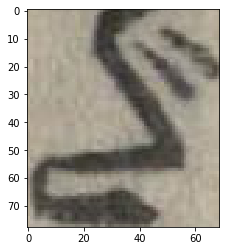

あ


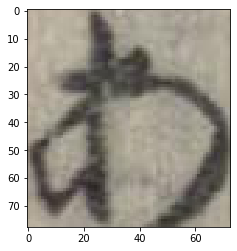

も


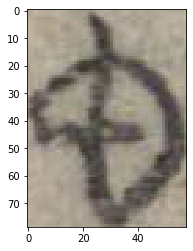

ア


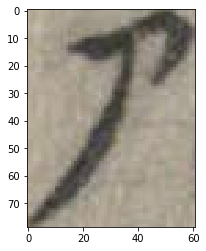

ね


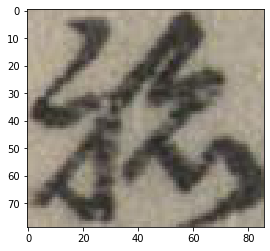

ウ


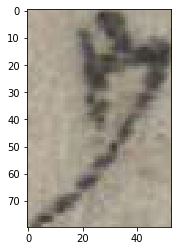

な


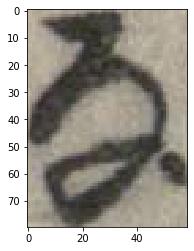

れ


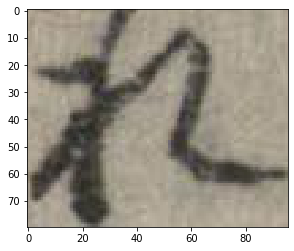

ら


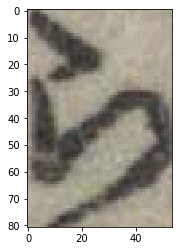

の


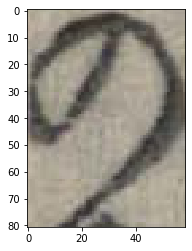

じ


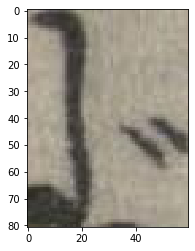

を


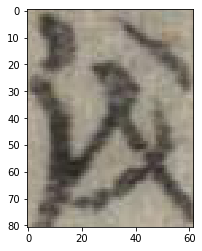

ね


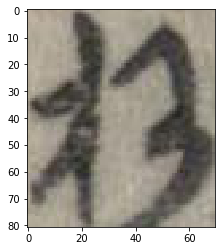

此


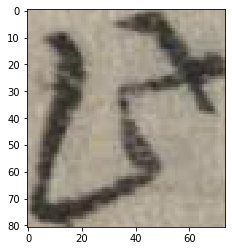

ん


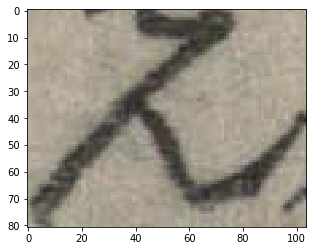

ら


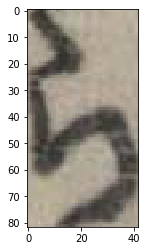

と


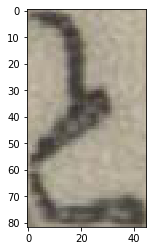

も


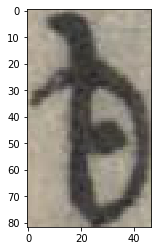

な


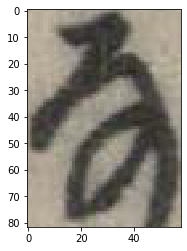

め


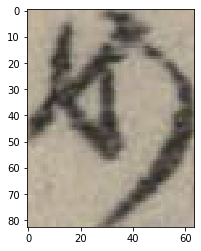

不


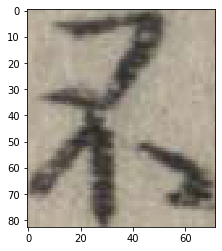

で


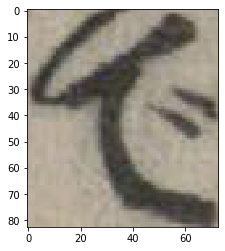

を


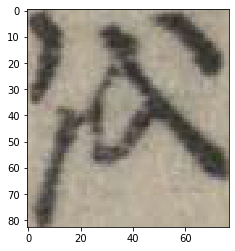

お


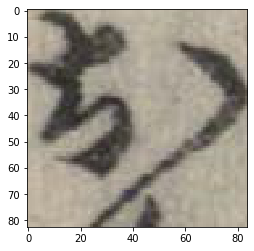

れ


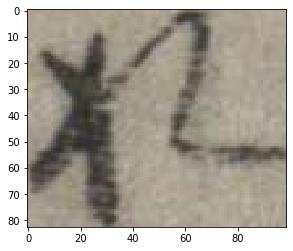

し


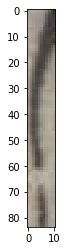

時


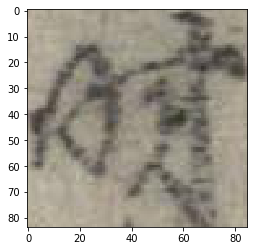

な


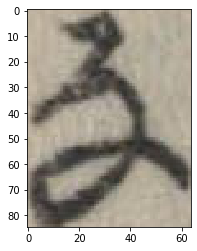

ね


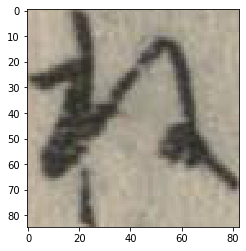

し


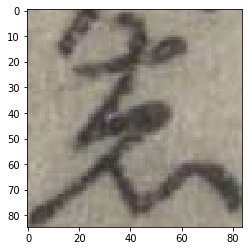

扨


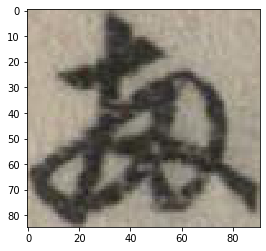

も


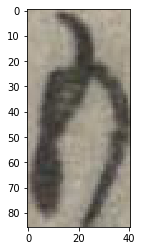

万


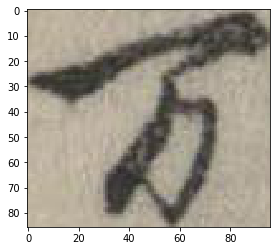

奴


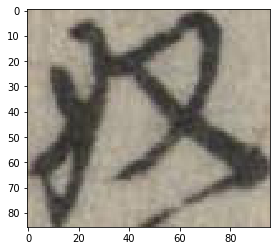

能


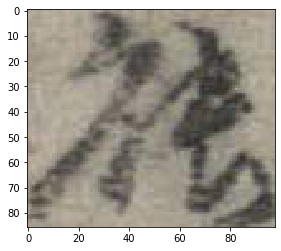

ん


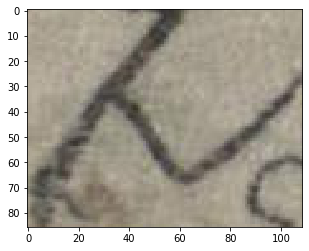

ま


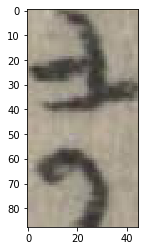

ら


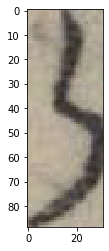

め


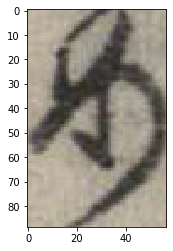

言


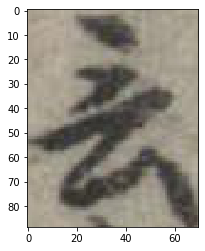

理


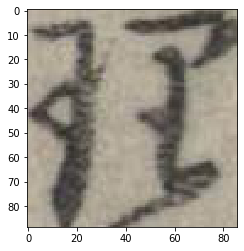

も


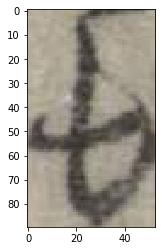

元


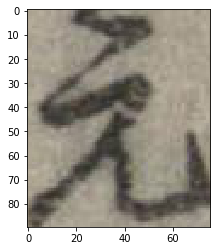

知


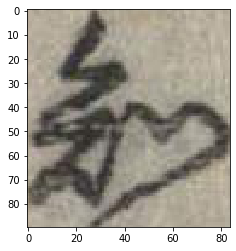

人


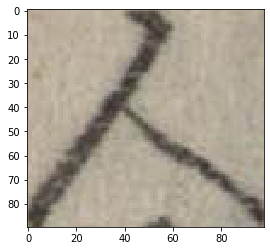

な


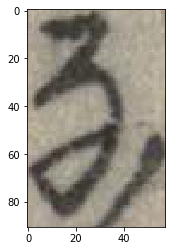

ま


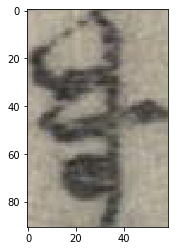

ぜ


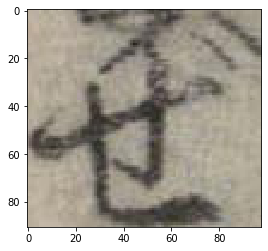

あ


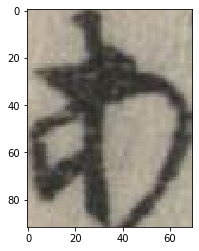

銭


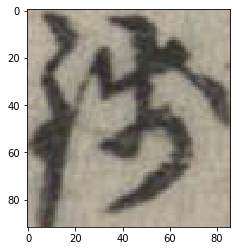

聞


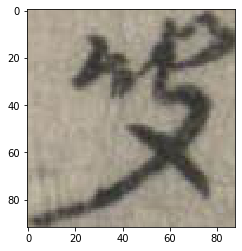

死


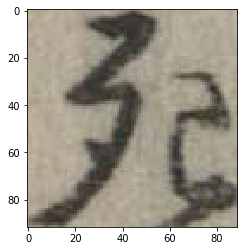

様


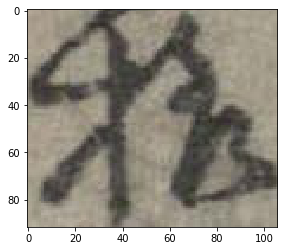

し


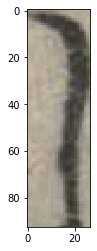

思


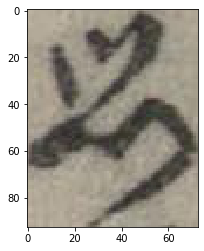

働


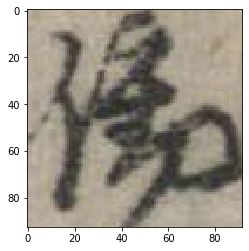

な


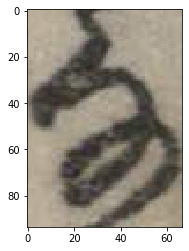

言


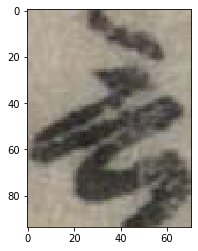

中


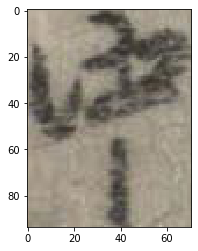

う


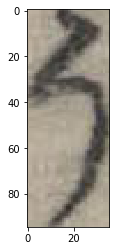

す


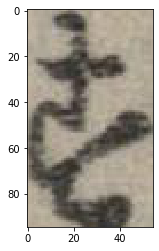

千


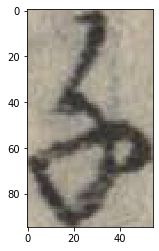

な


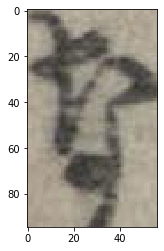

れ


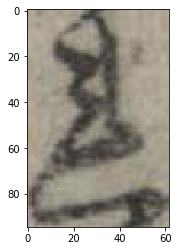

な


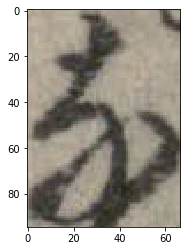

し


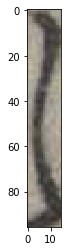

忌


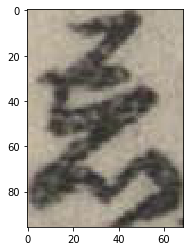

足


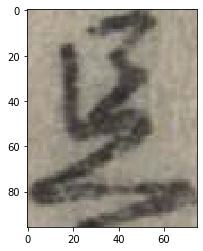

も


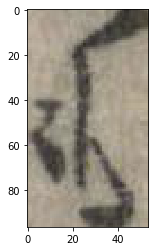

相


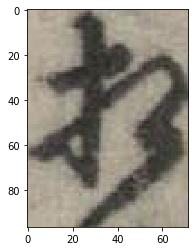

死


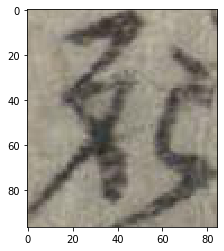

ね


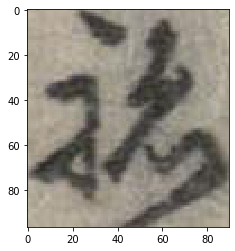

し


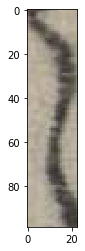

く


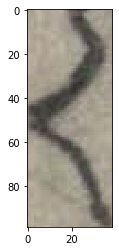

春


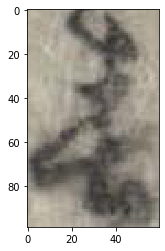

形


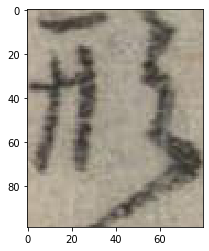

金


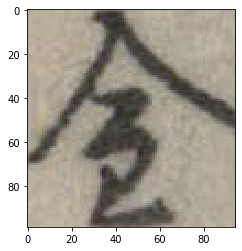

悪


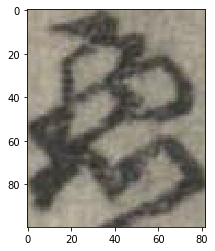

り


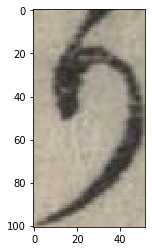

つ


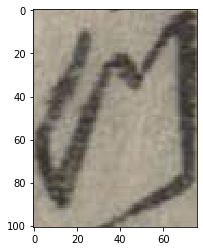

居


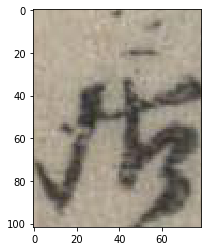

情


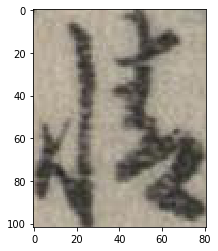

う


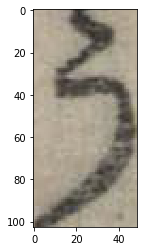

何


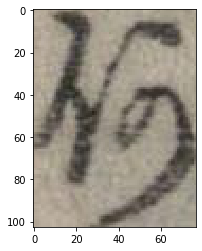

う


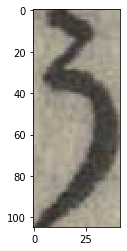

侭


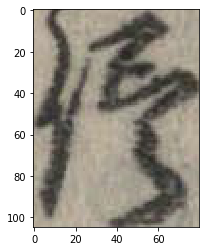

生


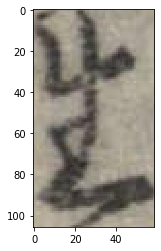

噺


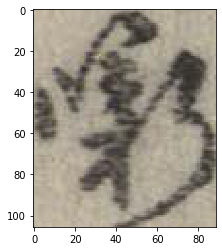

詮


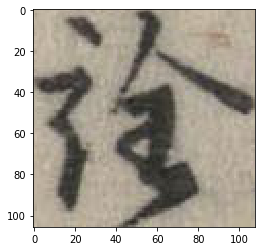

し


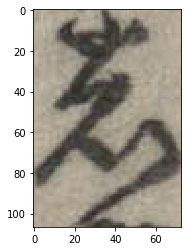

彼


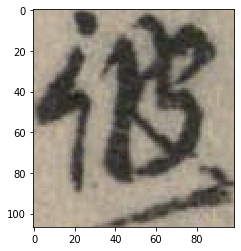

分


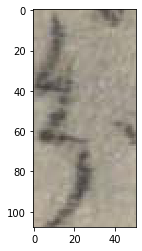

方


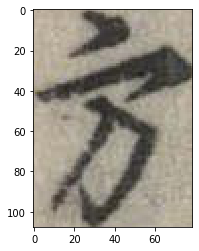

ん


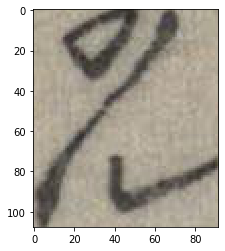

夫


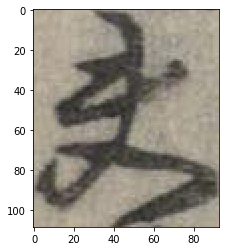

ゑ


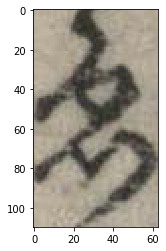

忌


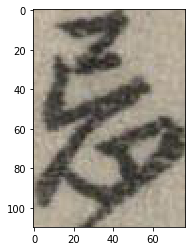

見


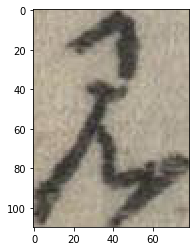

左


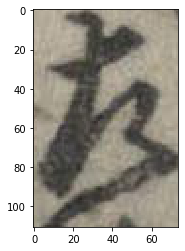

今


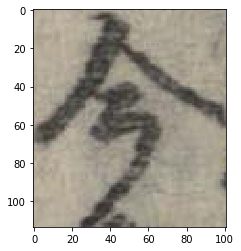

う


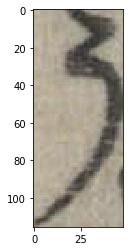

う


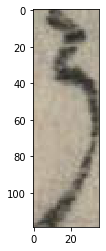

談


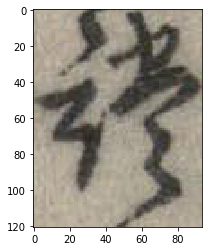

容


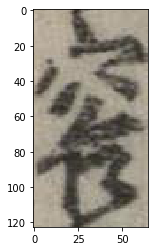

事


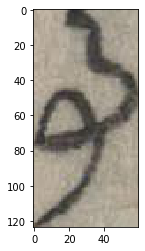

〱


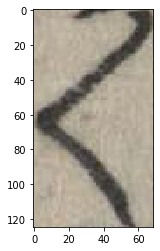

我


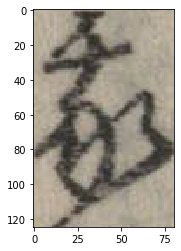

〱


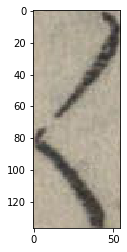

畜


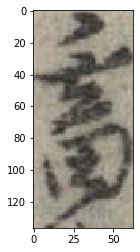

〱


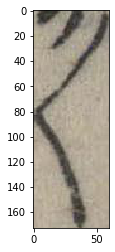

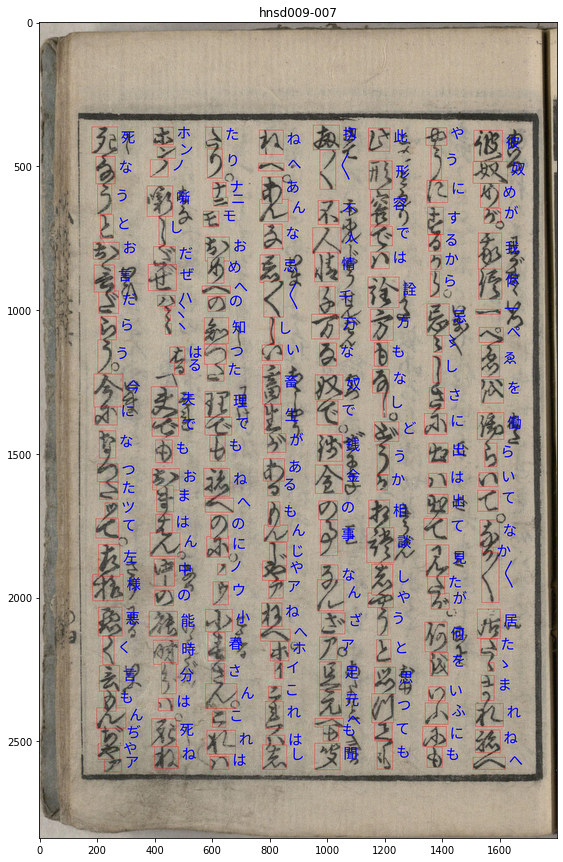

In [63]:
np.random.seed(1337)

for i in range(1):
    img, labels = df_train.values[np.random.randint(len(df_train))]
    viz = visualize_training_data('/content/sample_data/TrainData/{}.jpg'.format(img), labels)
    
    plt.figure(figsize=(15, 15))
    plt.title(img)
    plt.imshow(viz, interpolation='lanczos')
    plt.show()

In [0]:
def preProcessImage(image):
    #image = np.asarray(image)
    #image = image.resize((300,300))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,th1 = cv2.threshold(image,155,255,cv2.THRESH_BINARY)
    return th1


*   **Extract Data** crops out the kuzushiji from the image, resize it to a fixed size, covert it to grayscale and then does a Binary Threshold.
*   **Simple Thresholding** If pixel value is greater than a threshold value, it is assigned one value (may be white), else it is assigned another value (may be black). The function used is cv2.threshold. First argument is the source image, which should be a grayscale image. Second argument is the threshold value which is used to classify the pixel values. Third argument is the maxVal which represents the value to be given if pixel value is more than (sometimes less than) the threshold value. OpenCV provides different styles of thresholding and it is decided by the fourth parameter of the function


In [0]:
# This function takes in a filename of an image, and the labels in the string format given in a submission csv, and returns an image with the characters and predictions annotated.
def Extract_Data():
    X_=[]
    y_=[]
    # Convert annotation string to array #300
    for img, labels in tqdm(df_train[:420].values):
        try:
            image_fn = '/content/sample_data/TrainData/{}.jpg'.format(img)
            labels = np.array(labels.split(' ')).reshape(-1, 5)
            # Read image
            imsource = Image.open(image_fn).convert('RGBA')
            bbox_canvas = Image.new('RGBA', imsource.size)
            char_canvas = Image.new('RGBA', imsource.size)
            bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
            char_draw = ImageDraw.Draw(char_canvas)

            for codepoint, x, y, w, h in labels:
                x, y, w, h = int(x), int(y), int(w), int(h)
                char = unicode_map[codepoint] # Convert codepoint to actual unicode character

                # Draw bounding box around character, and unicode character next to it
                #bbox_draw.rectangle((x-10, y-10, x+10, y+10), fill=(255, 0, 0, 255))
                #char_draw.text((x+25, y-fontsize*(3/4)), char, fill=(255, 0, 0, 255), font=font)
                Croped_image = imsource.crop((x, y, x+w, y+h))
                image = Croped_image.resize((300,300))
                image = np.asarray(image)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                ret,th1 = cv2.threshold(image,155,255,cv2.THRESH_BINARY_INV)
                X_.append(th1)
                y_.append(str(unicode_map[codepoint]))
        except:
            pass
    X_ = np.array(X_)
    y_ = np.array(y_)

    '''imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") '''# Remove alpha for saving in jpg format.
    return X_,y_

In [73]:
XX_,yy_ = Extract_Data()

100%|██████████| 420/420 [01:18<00:00,  5.33it/s]


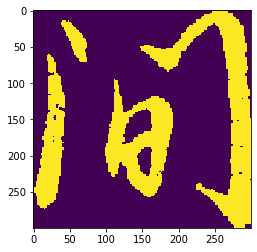

In [76]:
plt.figure()
plt.imshow(XX_[98])

In [77]:
XX_.shape

(49001, 300, 300)

In [78]:
unique, counts = np.unique(yy_, return_counts=True)
print(unique, counts )

['?' '▲' '○' ... '鼎' '鼻' '蓮'] [  1  54 198 ...   6   1   1]


In [79]:
NoOfClasses = len(unique)
NoOfClasses

1440

In [0]:
IMG_ROWS=300
IMG_COLS=300
def PreProcessData(X,y):
    lb = LabelEncoder()
    y_integer = lb.fit_transform(y)
    out_y = np_utils.to_categorical(y_integer)
    num_images = X.shape[0]
    out_x = X.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    #out_x = x_shaped_array / 255
    return out_x, out_y

In [0]:
lb = LabelEncoder()
y_integer = lb.fit_transform(yy_)
X,y = PreProcessData(XX_,yy_)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [82]:
K.clear_session()
def Kuzushiji_Classifier(in_):
    model_ = Conv2D(32,(3,3),activation='relu', padding="same")(in_)
    model_ = BatchNormalization()(model_)
    model_ =  Conv2D(32,(3, 3), activation='relu')(model_)
    model_ = BatchNormalization()(model_)
    model_ = Conv2D(32,5,strides=2,padding='same',activation='relu')(model_)
    model_ = MaxPooling2D((2, 2))(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(0.4)(model_)
    model_ = Conv2D(64,(3, 3), strides=2,padding='same', activation='relu')(model_)
    model_ = MaxPooling2D(pool_size=(2, 2))(model_)
    model_ = BatchNormalization()(model_)
    model_ = Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation='relu')(model_)
    model_ = Dropout(0.4)(model_)
    model_ = Flatten()(model_)
    model_ = Dense(128, activation='relu')(model_)
    model_ = Dropout(0.4)(model_)
    model_ = Dense(NoOfClasses, activation='softmax')(model_)
    return model_

In [83]:
Input_Sample = Input(shape=(300, 300,1))
Output_ = Kuzushiji_Classifier(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
Model_Enhancer.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 298, 298, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 298, 298, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 149, 149, 32)      25632    

In [0]:
checkpointer = ModelCheckpoint('model_Kuzushiji.h5', verbose=0,mode='auto', monitor='val_acc',save_best_only=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 36750 samples, validate on 12251 samples
Epoch 1/32
36750/36750 [==============================] - 352s 10ms/step - loss: 3.7825 - acc: 0.3289 - val_loss: 2.4716 - val_acc: 0.5501
Epoch 2/32
36750/36750 [==============================] - 342s 9ms/step - loss: 2.6029 - acc: 0.4962 - val_loss: 1.9350 - val_acc: 0.6480
Epoch 3/32
36750/36750 [==============================] - 342s 9ms/step - loss: 2.1593 - acc: 0.5641 - val_loss: 1.6740 - val_acc: 0.6955
Epoch 4/32
36750/36750 [==============================] - 342s 9ms/step - loss: 1.9193 - acc: 0.6010 - val_loss: 1.5082 - val_acc: 0.7240
Epoch 5/32
36750/36750 [==============================] - 341s 9ms/step - loss: 1.7320 - acc: 0.6302 - val_loss: 1.4248 - val_acc: 0.7388
Epoch 6/32
36750/36750 [==============================] - 341s 9ms/step - loss: 1.5917 - acc: 0.6510 - val_loss: 1.3375 - val_acc: 0.7579
Epoch 7/32
36750/36750 [=

Text(0.5, 1.0, 'Loss Curves')

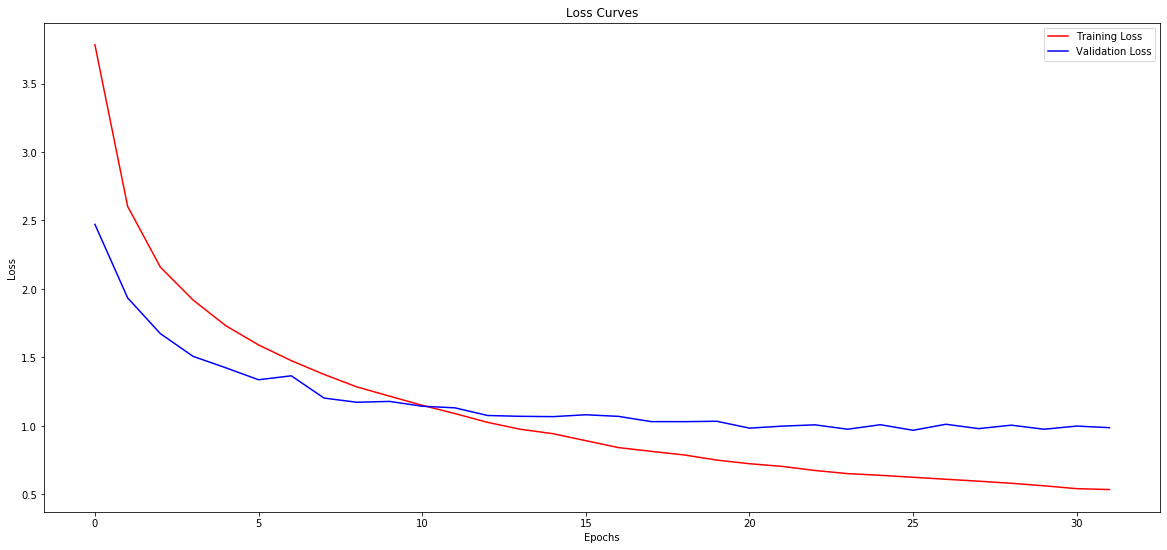

In [85]:
ModelHistory = Model_Enhancer.fit(X_train, y_train,
          batch_size=100,
          epochs=32,
          verbose=1,callbacks=[checkpointer],
          validation_data=(X_val, y_val))
#Loss Curves
plt.figure(figsize=[20,9])
plt.plot(ModelHistory.history['loss'], 'r')
plt.plot(ModelHistory.history['val_loss'], 'b')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

Text(0.5, 1.0, 'Accuracy Curves')

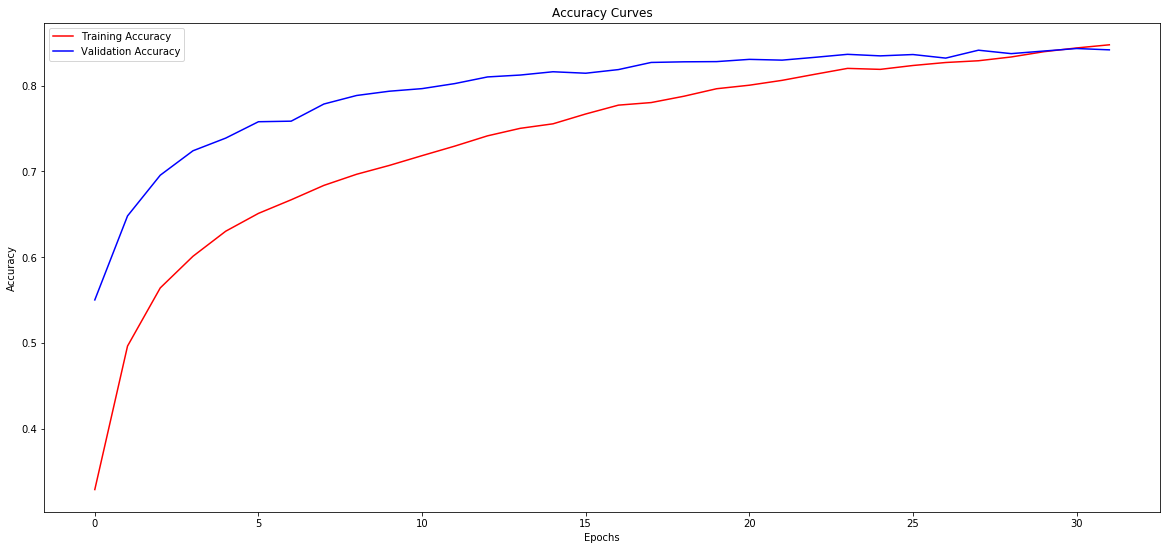

In [86]:
#Accuracy Curves
plt.figure(figsize=[20,9])
plt.plot(ModelHistory.history['acc'], 'r')
plt.plot(ModelHistory.history['val_acc'], 'b')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

In [0]:
def VisualizeKuzushiji(imagePath):
    img = cv2.imread(imagePath)
    imsource = Image.open(imagePath)#fromarray(img)
    char_draw = ImageDraw.Draw(imsource)
    im_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, im_th = cv2.threshold(im_grey, 130, 255, cv2.THRESH_BINARY_INV)
    ctrs,_ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    Kuzushijis = []
    for rect in rects:
        leng = int(rect[3] * 1.6)
        pt1 = int(rect[1] + rect[3]//2 - leng// 2)
        pt2 = int(rect[0] + rect[2]//2 - leng// 2)
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
        #bbox_draw.rectangle((rect[0], rect[1], rect[0] + rect[2],rect[1] + rect[3]), fill=(0, 225, 0, 0))
        #print(roi.size)
        if roi.size>7000:
            cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (225, 0, 0), 6)
            roi = cv2.resize(roi, (300,300))
            #roi = cv2.dilate(roi, (3, 3))
            ret,th1 = cv2.threshold(roi,155,255,cv2.THRESH_BINARY)
            ProcessImage = th1.reshape(1,IMG_ROWS, IMG_COLS, 1)
            y_pred = Model_.predict(ProcessImage)
            y_true = np.argmax(y_pred,axis=1)
            Kuzushiji = lb.inverse_transform(y_true)
            #print(Kuzushiji[0])
            Kuzushijis.append(str(Kuzushiji[0]))
            char_draw.text((rect[0]+10, rect[1]),str(Kuzushiji[0]), fill=(0,22,225,0), font=font)
            #cv2.putText(img, str(Kuzushiji[0]), (rect[0], rect[1]),font, 2, (0, 255, 255), 3)
    return img,imsource

In [0]:
img1, imsource1 = VisualizeKuzushiji('/content/100241706_00014_2.jpg')
plt.figure(figsize=(30,30))
plt.subplot(1,4,1)
plt.title("Detection of Kuzushiji",fontsize=20)
plt.imshow(img1)
plt.subplot(1,4,2)
plt.title("Recognition of Kuzushiji",fontsize=20)
plt.imshow(imsource1)